In [24]:
from undersampling import undersample_daily_weather_data, undersample_grid_data, DatabaseTables, FetchDBData
from imblearn.under_sampling import NearMiss
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
import numpy as np

import joblib

# DATA Combination and Undersampling

In [2]:
under_sampler = NearMiss(version=3, sampling_strategy=0.3)
weather_data, has_incident  = undersample_daily_weather_data(under_sampler, DatabaseTables.full_sampled_weather_with_incidents)
weather_data.loc[:, "has_incident"] = has_incident

Ratio Weather:
has_incident
False    1099
True      516
Name: count, dtype: int64


In [3]:
under_sampler = NearMiss(version=3, sampling_strategy=1)
grid_data, has_incident = undersample_grid_data(under_sampler)
grid_data.loc[:, "has_incident"] = has_incident

Ratio of Grids:
has_incident
0    1243
1    1243
Name: count, dtype: int64


In [4]:
incidents_grid_date = FetchDBData(DatabaseTables.count_tree_incidents_per_grid_date).get_database_data()

In [5]:
weather_data["dt_iso"] = weather_data["dt_iso"].astype(str).str.split(' ').apply(lambda x: x[0])

In [6]:
incidents_grid_date["date"] = incidents_grid_date["date"].astype(str)

In [7]:
weather_data_incidents = weather_data.query("`has_incident` == 1").merge(incidents_grid_date, left_on="dt_iso", right_on="date")

In [8]:
weather_grid_has_incident = (
    weather_data_incidents
    .drop(["count_incidents_y", "count_incidents_x", "max_incident_priority", "has_incident"], axis=1)
    .merge(grid_data, on="grid_id")
)

In [9]:
weather_grid_no_incident = grid_data.query("`has_incident` == 0").merge(weather_data_incidents, how="cross").drop(["count_incidents_y", "count_incidents_x", "max_incident_priority", "has_incident_y", "grid_id_y"], axis=1).rename(columns={"grid_id_x": "grid_id", "has_incident_x": "has_incident"})

In [10]:
weather_data_no_incidents = weather_data.query("`has_incident` == 0").merge(incidents_grid_date, left_on="dt_iso", right_on="date")
weather_grid_weather_no_incidents = grid_data.query("`has_incident` == 0").merge(weather_data_incidents, how="cross").drop(["count_incidents_y", "count_incidents_x", "max_incident_priority", "has_incident_y", "grid_id_y"], axis=1).rename(columns={"grid_id_x": "grid_id", "has_incident_x": "has_incident"})

In [11]:
weather_grid_weather_no_incidents = weather_grid_weather_no_incidents[weather_grid_has_incident.columns]

In [12]:
weather_grid_no_incident = weather_grid_no_incident[weather_grid_has_incident.columns]

In [13]:
combined_data = pd.concat([
    weather_grid_has_incident, 
    weather_grid_weather_no_incidents, 
    weather_grid_no_incident])
combined_data = combined_data.drop(["hour","date","total_incident_duration"], axis=1)

In [14]:
combined_data = combined_data.drop(["grid_id", "weather_main", "dt_iso"], axis=1)

In [15]:
combined_data.has_incident.value_counts()

has_incident
0    3930366
1       1521
Name: count, dtype: int64

# Modeling

In [16]:
exclude_cols = [
    "dt_iso",
    "grid_id",
]

target_col = 'has_incident'

predictor_cols =[col for col in combined_data.columns if col not in [target_col]]
one_hot_cols = ["weather_main"]
numeric_cols = [col for col in predictor_cols if col not in exclude_cols + one_hot_cols]

X = combined_data[predictor_cols]
y = combined_data[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [17]:
y_train.value_counts()

has_incident
0    3144292
1       1217
Name: count, dtype: int64

In [18]:
y_test.value_counts()

has_incident
0    786074
1       304
Name: count, dtype: int64

In [16]:
model = lgb.LGBMClassifier(
    metric='binary_error', 
    boosting_type='gbdt', 
    class_weight={False: 0.000001, True: 0.99999},
    n_estimators=1_000,
    verbose=-1,
)
  
model.fit(X_train, y_train) 
  
y_pred = model.predict(X_test)

data = pd.DataFrame(
    {
        "actual": y_test.reset_index().drop("index", axis=1)["has_incident"],
        "predicted": y_pred,
    }, 
)

print(pd.crosstab(data.actual, data.predicted))
print(f1_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

KeyboardInterrupt: 

In [30]:
boundary = 0.04

params = {
    'boosting_type': 'gbdt',
    'reg_alpha': 1,
    'reg_lambda': 5,
    'num_leaves': 90,
    'num_boost_round': 1_000,
    'scale_pos_weight': 20_000,
    'metric': 'binary_error',
    'verbose': 0
}

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.where(y_hat < boundary, 0, 1)
    return 'f1', f1_score(y_true, y_hat), True

model = lgb.train(params, lgb.Dataset(X_train, label=y_train), feval=lgb_f1_score)

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

data = pd.DataFrame(
    {
        "actual": y_test.reset_index().drop("index", axis=1)["has_incident"],
        "predicted": np.where(y_pred <  boundary, 0, 1),
    }, 
)

print(pd.crosstab(data.actual, data.predicted))

f1 = f1_score(y_test, np.where(y_pred < boundary, 0, 1))
recall = recall_score(y_test, np.where(y_pred < boundary, 0, 1))
precision = precision_score(y_test, np.where(y_pred < boundary, 0, 1))
accuracy = accuracy_score(y_test, np.where(y_pred < boundary, 0, 1))
print(f"="*100)
print(f"Accuracy in testing: {accuracy}")
print(f"F1 Score in testing: {f1}")
print(f"Recall Score in testing: {recall}")
print(f"Precision in testing: {precision}")
print(f"="*100) 

predicted       0    1
actual                
0          786071    3
1              72  232
Accuracy in testing: 0.9999046260195479
F1 Score in testing: 0.8608534322820037
Recall Score in testing: 0.7631578947368421
Precision in testing: 0.9872340425531915


In [ ]:
joblib.dump(model, f"lightgbm_model_{f1:.2f}.joblib")

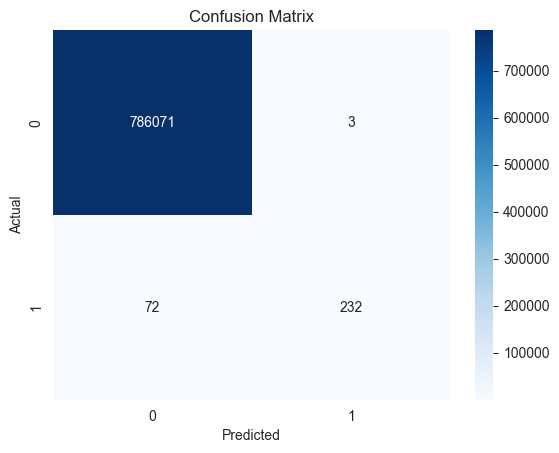

In [33]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

conf_matrix = pd.crosstab(data.actual, data.predicted)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()